In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path


In [8]:
DATA_PATH = "C:\\IP\\greenmlops\\data\\raw\\ett\\ETTh1.csv"
OUT_DIR   = Path("C:\\IP\\greenmlops\\data\\processed\\ett")

In [9]:
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [10]:
df = pd.read_csv(DATA_PATH, parse_dates=["date"])

In [11]:
df.shape

(17420, 8)

In [12]:
df.columns.tolist()

['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

In [13]:
df.dtypes

date    datetime64[ns]
HUFL           float64
HULL           float64
MUFL           float64
MULL           float64
LUFL           float64
LULL           float64
OT             float64
dtype: object

In [14]:
df.head(3)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001


In [15]:
df.isnull().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

In [16]:
df.describe().T[["mean", "std", "min", "max"]]

,mean,std,min,max
date,2017-06-28 21:30:00,NaN,2016-07-01 00:00:00,2018-06-26 19:00:00
HUFL,7.375141,7.067744,-22.705999,23.643999
HULL,2.242242,2.042342,-4.756,10.114
MUFL,4.300239,6.826978,-25.087999,17.341
MULL,0.881568,1.809293,-5.934,7.747
LUFL,3.066062,1.164506,-1.188,8.498
LULL,0.856932,0.599552,-1.371,3.046
OT,13.324672,8.566946,-4.08,46.007


###  Temporal checks

In [17]:
print("\n=== TEMPORAL ===")
print(f"Start : {df['date'].min()}")
print(f"End   : {df['date'].max()}")
print(f"Total hours: {len(df)}")
expected = int((df['date'].max() - df['date'].min()).total_seconds() / 3600) + 1
print(f"Expected hours (no gaps): {expected}")
print(f"Missing timestamps: {expected - len(df)}")


=== TEMPORAL ===
Start : 2016-07-01 00:00:00
End   : 2018-06-26 19:00:00
Total hours: 17420
Expected hours (no gaps): 17420
Missing timestamps: 0


In [18]:
dups = df['date'].duplicated().sum()
print(f"Duplicate timestamps: {dups}")

Duplicate timestamps: 0


### Feature analysis

In [19]:
feature_cols = [c for c in df.columns if c != "date"]
print("\n=== FEATURE CORRELATIONS WITH OT ===")
print(df[feature_cols].corr()["OT"].sort_values(ascending=False))


=== FEATURE CORRELATIONS WITH OT ===
OT      1.000000
HULL    0.224354
MULL    0.220004
LUFL    0.118836
LULL    0.067455
HUFL    0.059916
MUFL    0.050854
Name: OT, dtype: float64


In [20]:
for col in feature_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    n_out = ((df[col] < Q1 - 3*IQR) | (df[col] > Q3 + 3*IQR)).sum()
    print(f"  {col}: {n_out} outliers")

  HUFL: 481 outliers
  HULL: 0 outliers
  MUFL: 791 outliers
  MULL: 0 outliers
  LUFL: 154 outliers
  LULL: 279 outliers
  OT: 0 outliers


### Plots


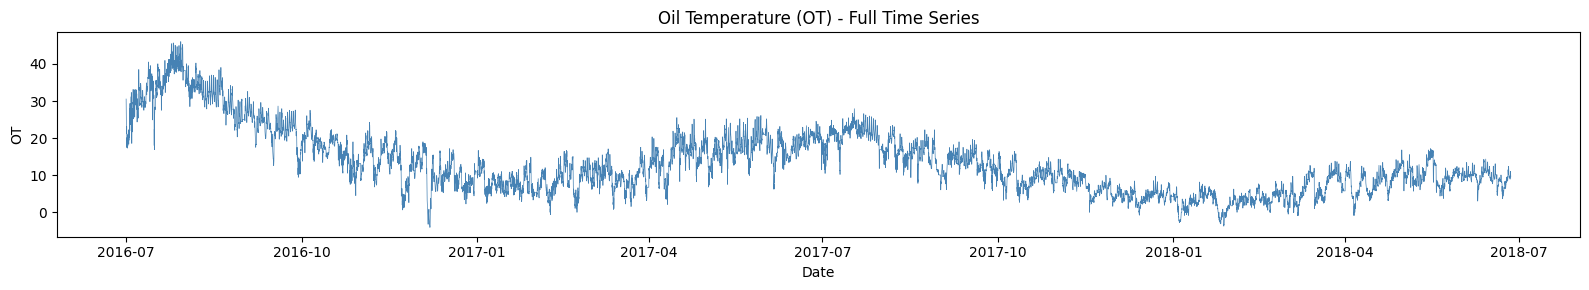

In [31]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(df["date"], df["OT"], linewidth=0.5, color="steelblue")
ax.set_title("Oil Temperature (OT) - Full Time Series")
ax.set_xlabel("Date")
ax.set_ylabel("OT")
plt.tight_layout()
plt.show()

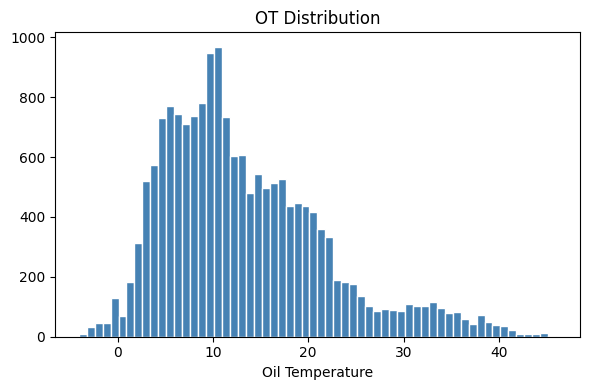

In [32]:
#OT Distribution
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(df["OT"], bins=60, color="steelblue", edgecolor="white")
ax.set_title("OT Distribution")
ax.set_xlabel("Oil Temperature")
plt.tight_layout()
plt.show()

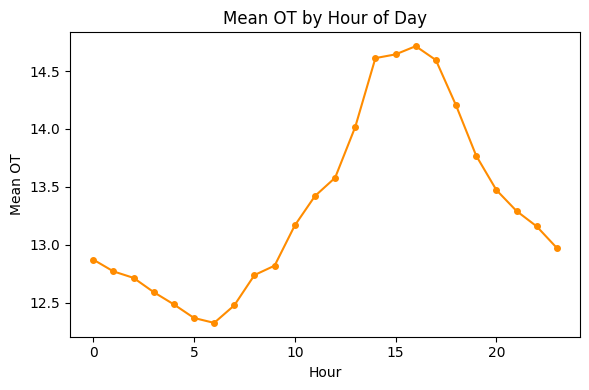

In [33]:
#Hourly Seasonality
fig, ax = plt.subplots(figsize=(6, 4))
hourly_mean = df.groupby(df["date"].dt.hour)["OT"].mean()
ax.plot(hourly_mean.index, hourly_mean.values, marker="o", markersize=4, color="darkorange")
ax.set_title("Mean OT by Hour of Day")
ax.set_xlabel("Hour")
ax.set_ylabel("Mean OT")
plt.tight_layout()
plt.show()

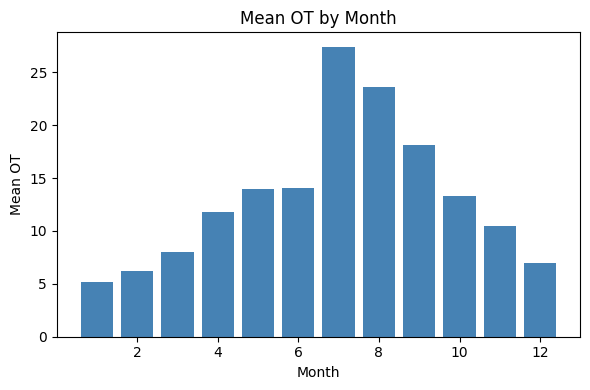

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
monthly_mean = df.groupby(df["date"].dt.month)["OT"].mean()
ax.bar(monthly_mean.index, monthly_mean.values, color="steelblue")
ax.set_title("Mean OT by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Mean OT")
plt.tight_layout()
plt.show()

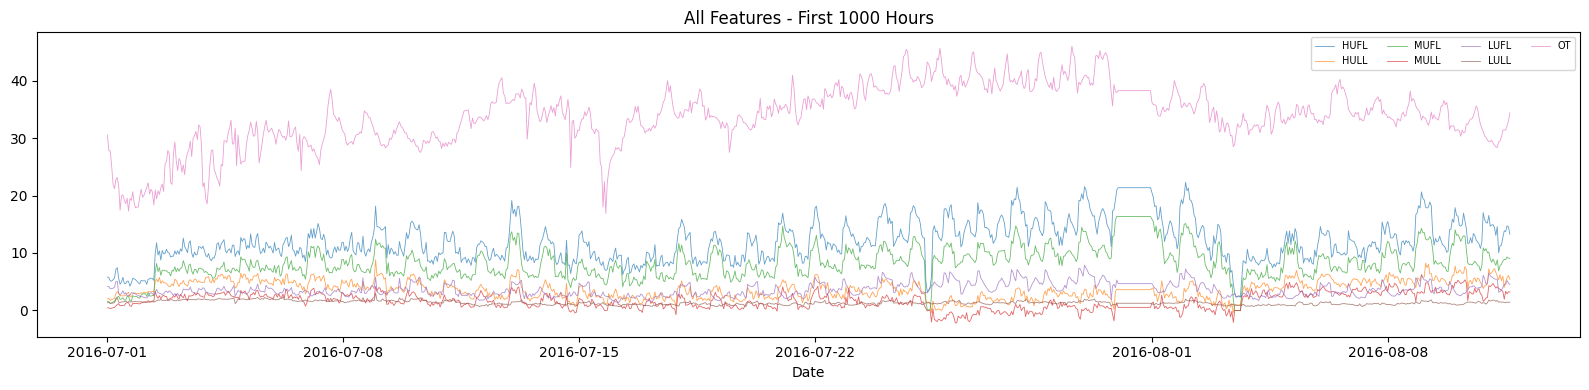

In [36]:
fig, ax = plt.subplots(figsize=(16, 4))
for col in feature_cols:
    ax.plot(df["date"].iloc[:1000], df[col].iloc[:1000], linewidth=0.6, label=col, alpha=0.7)
ax.set_title("All Features - First 1000 Hours")
ax.legend(fontsize=7, ncol=4)
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

### Cleaning


In [39]:
df_clean = df.copy()
df_clean = df_clean.drop(columns=["hour", "month"], errors="ignore")
df_clean = df_clean.sort_values("date").reset_index(drop=True)

# Fill any missing timestamps with forward fill 
df_clean = df_clean.set_index("date").asfreq("h", method="ffill").reset_index()

# Verify no nulls remain
assert df_clean.isnull().sum().sum() == 0, "Nulls remain after cleaning"

print(f" CLEAN SHAPE") 
print(df_clean.shape)
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")

 CLEAN SHAPE
(17420, 8)
Date range: 2016-07-01 00:00:00 to 2018-06-26 19:00:00
